<a href="https://colab.research.google.com/github/mastersigat/GeoPandas/blob/main/Cadastre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration environnement de travail

In [ ]:
#Initialisation de l'environnement avec geopandas
!apt update
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Instal contextily (fonds de carte)
!pip install contextily
# Install mapclassify (cartographie thématique)
!pip install mapclassify
#Depuis sa version 0.8, Geopandas peut fonctionner de manière expérimental avec Pygeos ce qui accèlère certaines opérations
!pip install pygeos
# Pour la cartographie interactive
!pip install folium

In [ ]:
#Importation des librairies nécessaires
import pandas as pd #Gestion de données
import matplotlib as plt #Visualisation de données
import geopandas as gpd #Gestion données spatiales
import pygeos #Opérations sur les géométrie de données spatiales
import contextily as ctx #Fonds de carte
import numpy as np #Manipulation de tableaux
import shapely #Manipulation de géométrie
import folium #Cartographie interactive
import mapclassify #Cartographie thématique

# Importation des données (cadastre.data.gouv.fr)

Nous travaillons ici sur la commune de Cesson Sévigné (code insee 35051)

In [ ]:
#Téléchargement des datas depuis cadastre.data.gouv
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35051/shp/batiments -O batiments.zip
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35051/shp/parcelles -O parcelles.zip
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35051/shp/sections -O sections.zip

,commune,nom,type,created,updated,geometry
0,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357222.008 6790493.977, 357213.758 6..."
1,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357187.130 6790473.351, 357193.638 6..."
2,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357208.471 6790399.177, 357213.178 6..."


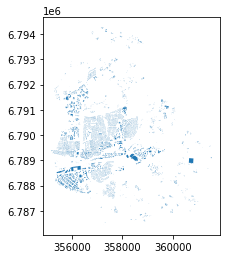

In [ ]:
#Chargement couche Batiments
Batiments= gpd.read_file("batiments.zip", encoding='utf-8')
Batiments.plot()
Batiments.head(3)

In [ ]:
#Compter le nombre de batiments
len(Batiments)

9047

,id,commune,prefixe,section,numero,contenance,created,updated,geometry
0,35051000AA0562,35051,000,AA,562,42655.0,2020-06-16,2021-01-29,"POLYGON ((357147.131 6790343.595, 357174.713 6..."
1,35051000AA0564,35051,000,AA,564,21375.0,2020-06-16,2021-01-29,"POLYGON ((357023.822 6790674.048, 357025.859 6..."
2,35051000AA0563,35051,000,AA,563,6378.0,2020-06-16,2021-01-29,"POLYGON ((357515.617 6790355.263, 357541.619 6..."


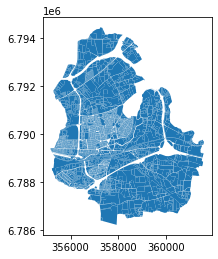

In [ ]:
#Chargement couche Parcelles
Parcelles= gpd.read_file("parcelles.zip", encoding='utf-8')
Parcelles.plot()
Parcelles.head(3)

In [ ]:
#Compter le nombre de parcelles
len(Parcelles)

8949

,id,commune,prefixe,code,created,updated,geometry
0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,"POLYGON ((357095.719 6790338.898, 357089.990 6..."
1,35051000AB,35051,000,AB,2020-06-16,2020-06-22,"POLYGON ((357603.646 6790021.629, 357544.963 6..."
2,35051000AC,35051,000,AC,2020-06-16,2020-06-22,"POLYGON ((357841.087 6789716.194, 357850.289 6..."


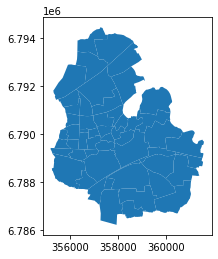

In [ ]:
#Chargement couche Sections
Sections= gpd.read_file("sections.zip", encoding='utf-8')
Sections.plot()
Sections.head(3)

# Préparation des couches

In [ ]:
# Vérifier le SCR des couches

Batiments.crs
Parcelles.crs
Sections.crs

<Projected CRS: EPSG:2154>
Name: RGF93 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica.
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
#Créer un ID unique pour chaque batiment (id unique)

Batiments["ID_Bati"] = Batiments.index
Batiments.head()

,commune,nom,type,created,updated,geometry,ID_Bati
0,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357222.008 6790493.977, 357213.758 6...",0
1,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357187.130 6790473.351, 357193.638 6...",1
2,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357208.471 6790399.177, 357213.178 6...",2
3,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357201.063 6790536.791, 357202.418 6...",3
4,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357170.131 6790496.341, 357177.821 6...",4


In [ ]:
# Créer un ID unique pour chaque parcelle (concaténation de deux champs)

Parcelles["ID_Parcelle"] = Parcelles["prefixe"] + "-" + Parcelles["section"] + "-" + Parcelles["numero"]
Parcelles.head(3)

,id,commune,prefixe,section,numero,contenance,created,updated,geometry,ID_Parcelle
0,35051000AA0562,35051,000,AA,562,42655.0,2020-06-16,2021-01-29,"POLYGON ((357147.131 6790343.595, 357174.713 6...",000-AA-562
1,35051000AA0564,35051,000,AA,564,21375.0,2020-06-16,2021-01-29,"POLYGON ((357023.822 6790674.048, 357025.859 6...",000-AA-564
2,35051000AA0563,35051,000,AA,563,6378.0,2020-06-16,2021-01-29,"POLYGON ((357515.617 6790355.263, 357541.619 6...",000-AA-563


In [ ]:
# Créer un ID unique pour chaque section (concaténation de deux champs)

Sections["ID_Section"] = Sections["prefixe"] + "-" + Sections["code"]
Sections.head(3)

,id,commune,prefixe,code,created,updated,geometry,ID_Section
0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,"POLYGON ((357095.719 6790338.898, 357089.990 6...",000-AA
1,35051000AB,35051,000,AB,2020-06-16,2020-06-22,"POLYGON ((357603.646 6790021.629, 357544.963 6...",000-AB
2,35051000AC,35051,000,AC,2020-06-16,2020-06-22,"POLYGON ((357841.087 6789716.194, 357850.289 6...",000-AC


In [ ]:
# Ajouter une colonne surface aux sections cadastrales

Sections["Surface_Section"] = Sections['geometry'].area
Sections.head(3) 

,id,commune,prefixe,code,created,updated,geometry,ID_Section,Surface_Section
0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,"POLYGON ((357095.719 6790338.898, 357089.990 6...",000-AA,369064.681658
1,35051000AB,35051,000,AB,2020-06-16,2020-06-22,"POLYGON ((357603.646 6790021.629, 357544.963 6...",000-AB,214286.256561
2,35051000AC,35051,000,AC,2020-06-16,2020-06-22,"POLYGON ((357841.087 6789716.194, 357850.289 6...",000-AC,142503.178738


In [ ]:
# Ajouter une colonne surface aux parcelles cadastrales

Parcelles["Surface_Parcelle"] = Parcelles['geometry'].area
Parcelles.head(3) 

,id,commune,prefixe,section,numero,contenance,created,updated,geometry,ID_Parcelle,Surface_Parcelle
0,35051000AA0562,35051,000,AA,562,42655.0,2020-06-16,2021-01-29,"POLYGON ((357147.131 6790343.595, 357174.713 6...",000-AA-562,42589.708869
1,35051000AA0564,35051,000,AA,564,21375.0,2020-06-16,2021-01-29,"POLYGON ((357023.822 6790674.048, 357025.859 6...",000-AA-564,23922.911984
2,35051000AA0563,35051,000,AA,563,6378.0,2020-06-16,2021-01-29,"POLYGON ((357515.617 6790355.263, 357541.619 6...",000-AA-563,5647.585310


In [ ]:
# Ajouter une colonne surface aux batiments

Batiments["Surface_Batiment"] = Batiments['geometry'].area
Batiments.head(3) 

,commune,nom,type,created,updated,geometry,ID_Bati,Surface_Batiment
0,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357222.008 6790493.977, 357213.758 6...",0,100.642954
1,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357187.130 6790473.351, 357193.638 6...",1,92.067686
2,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357208.471 6790399.177, 357213.178 6...",2,114.465134


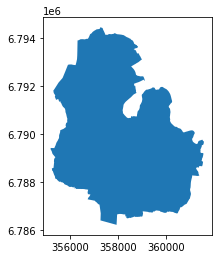

In [ ]:
# Créer une couche avec l'emprise de Cesson

Cesson = Sections.dissolve(by="commune")
Cesson.plot()

# Analyses spatiales

*   Compter le nombre de bâtiments par section cadastrale
*   Compter le nombre de bâtiments par parcelle cadastrale
*   Calculer la proportion de surface des bâtiments par parcelle cadastrale 

## Compter le nombre de bâtiments par section cadastrale


,commune,nom,type,created,updated,geometry,ID_Bati,Surface_Batiment
0,35051,None,01,2020-06-16,2020-06-22,POINT (357214.927 6790493.368),0,100.642954
1,35051,None,01,2020-06-16,2020-06-22,POINT (357186.831 6790466.391),1,92.067686
2,35051,None,01,2020-06-16,2020-06-22,POINT (357216.900 6790398.322),2,114.465134


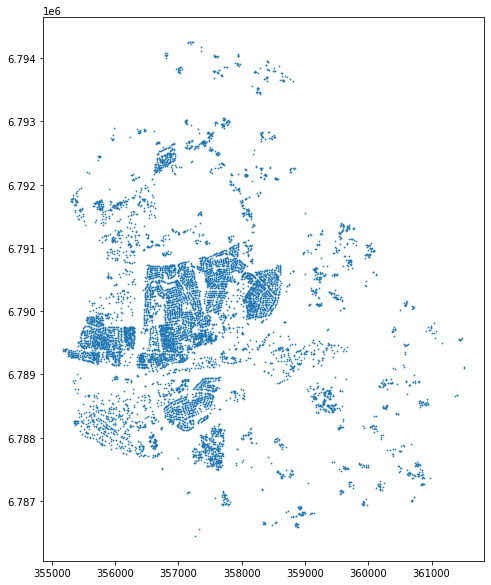

In [ ]:
#Transformer les batiments (polygones) en points (centroides)

BatimentsCentro = Batiments.copy()
BatimentsCentro.geometry = BatimentsCentro['geometry'].centroid
BatimentsCentro.crs =Batiments.crs
BatimentsCentro.plot(figsize=(300,10), markersize=0.5, legend=True)
BatimentsCentro.head(3)

In [ ]:
# Encrichir les batiments des informations de la couche des Sections Cadastrales (jointure spatiale)

BatimentsEtape1 = gpd.sjoin(BatimentsCentro, Sections)
BatimentsEtape1.head(5)

,commune_left,nom,type,created_left,updated_left,geometry,ID_Bati,Surface_Batiment,index_right,id,commune_right,prefixe,code,created_right,updated_right,ID_Section,Surface_Section
0,35051,None,01,2020-06-16,2020-06-22,POINT (357214.927 6790493.368),0,100.642954,0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,000-AA,369064.681658
1,35051,None,01,2020-06-16,2020-06-22,POINT (357186.831 6790466.391),1,92.067686,0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,000-AA,369064.681658
2,35051,None,01,2020-06-16,2020-06-22,POINT (357216.900 6790398.322),2,114.465134,0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,000-AA,369064.681658
3,35051,None,01,2020-06-16,2020-06-22,POINT (357196.770 6790531.821),3,139.128770,0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,000-AA,369064.681658
4,35051,None,01,2020-06-16,2020-06-22,POINT (357176.881 6790496.643),4,107.707947,0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,000-AA,369064.681658


In [ ]:
#Réorganiser la table

BatimentsEtape2 = BatimentsEtape1[["ID_Bati", "type", "code", "Surface_Batiment", "ID_Section", "Surface_Section", "geometry"]]
BatimentsEtape2.head(3)

,ID_Bati,type,code,Surface_Batiment,ID_Section,Surface_Section,geometry
0,0,01,AA,100.642954,000-AA,369064.681658,POINT (357214.927 6790493.368)
1,1,01,AA,92.067686,000-AA,369064.681658,POINT (357186.831 6790466.391)
2,2,01,AA,114.465134,000-AA,369064.681658,POINT (357216.900 6790398.322)


In [ ]:
# Encrichir les batiments des informations de la couche des parcelles Cadastrales (jointure spatiale)

BatimentsEtape3 = gpd.sjoin(BatimentsEtape2, Parcelles)
BatimentsEtape3.head(3)

,ID_Bati,type,code,Surface_Batiment,ID_Section,Surface_Section,geometry,index_right,id,commune,prefixe,section,numero,contenance,created,updated,ID_Parcelle,Surface_Parcelle
0,0,01,AA,100.642954,000-AA,369064.681658,POINT (357214.927 6790493.368),15,35051000AA0126,35051,000,AA,126,580.0,2020-06-16,2021-01-29,000-AA-126,584.534522
1,1,01,AA,92.067686,000-AA,369064.681658,POINT (357186.831 6790466.391),14,35051000AA0124,35051,000,AA,124,468.0,2020-06-16,2021-01-29,000-AA-124,470.937329
2,2,01,AA,114.465134,000-AA,369064.681658,POINT (357216.900 6790398.322),22,35051000AA0119,35051,000,AA,119,513.0,2020-06-16,2021-01-29,000-AA-119,511.476178


In [ ]:
#Réorganiser la table

BatimentsFinal = BatimentsEtape3[["ID_Bati", "type", "code", "Surface_Batiment", "ID_Section", "Surface_Section", "ID_Parcelle", "Surface_Parcelle", "geometry"]]
BatimentsFinal.head(3)

,ID_Bati,type,code,Surface_Batiment,ID_Section,Surface_Section,ID_Parcelle,Surface_Parcelle,geometry
0,0,01,AA,100.642954,000-AA,369064.681658,000-AA-126,584.534522,POINT (357214.927 6790493.368)
1,1,01,AA,92.067686,000-AA,369064.681658,000-AA-124,470.937329,POINT (357186.831 6790466.391)
2,2,01,AA,114.465134,000-AA,369064.681658,000-AA-119,511.476178,POINT (357216.900 6790398.322)


In [ ]:
# Jointure attributaire pour repasser sur la couche des polygones

BatimentsFinalOk = Batiments.merge(BatimentsFinal, on='ID_Bati')
BatimentsFinalOk.head(3)

,commune,nom,type_x,created,updated,geometry_x,ID_Bati,Surface_Batiment_x,type_y,code,Surface_Batiment_y,ID_Section,Surface_Section,ID_Parcelle,Surface_Parcelle,geometry_y
0,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357222.008 6790493.977, 357213.758 6...",0,100.642954,01,AA,100.642954,000-AA,369064.681658,000-AA-126,584.534522,POINT (357214.927 6790493.368)
1,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357187.130 6790473.351, 357193.638 6...",1,92.067686,01,AA,92.067686,000-AA,369064.681658,000-AA-124,470.937329,POINT (357186.831 6790466.391)
2,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357208.471 6790399.177, 357213.178 6...",2,114.465134,01,AA,114.465134,000-AA,369064.681658,000-AA-119,511.476178,POINT (357216.900 6790398.322)


In [ ]:
#Réorganiser la table
BatimentsFinalOk = BatimentsFinalOk[["ID_Bati", "type_x", "Surface_Batiment_x", "ID_Section", "Surface_Section", "ID_Parcelle", "Surface_Parcelle", "geometry_x"]]
BatimentsFinalOk.rename(columns={'type_x': 'type','Surface_Batiment_x': 'Surface_Batiment','geometry_x': 'Geometry'}, inplace=True)
BatimentsFinalOk.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ID_Bati,type,Surface_Batiment,ID_Section,Surface_Section,ID_Parcelle,Surface_Parcelle,Geometry
0,0,01,100.642954,000-AA,369064.681658,000-AA-126,584.534522,"POLYGON ((357222.008 6790493.977, 357213.758 6..."
1,1,01,92.067686,000-AA,369064.681658,000-AA-124,470.937329,"POLYGON ((357187.130 6790473.351, 357193.638 6..."
2,2,01,114.465134,000-AA,369064.681658,000-AA-119,511.476178,"POLYGON ((357208.471 6790399.177, 357213.178 6..."
3,3,01,139.128770,000-AA,369064.681658,000-AA-78,669.431314,"POLYGON ((357201.063 6790536.791, 357202.418 6..."
4,4,01,107.707947,000-AA,369064.681658,000-AA-82,577.485702,"POLYGON ((357170.131 6790496.341, 357177.821 6..."


,ID_Bati,type,Surface_Batiment,ID_Section,Surface_Section,ID_Parcelle,Surface_Parcelle,Geometry
0,0,01,100.642954,000-AA,369064.681658,000-AA-126,584.534522,"POLYGON ((357222.008 6790493.977, 357213.758 6..."
1,1,01,92.067686,000-AA,369064.681658,000-AA-124,470.937329,"POLYGON ((357187.130 6790473.351, 357193.638 6..."
2,2,01,114.465134,000-AA,369064.681658,000-AA-119,511.476178,"POLYGON ((357208.471 6790399.177, 357213.178 6..."


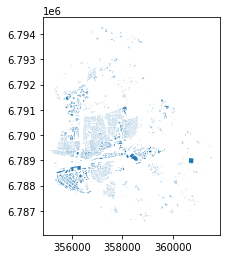

In [ ]:
#Repasser en GeoDataframe

BatiOK = gpd.GeoDataFrame(BatimentsFinalOk, crs="EPSG:2154", geometry='Geometry')
BatiOK.plot()
BatiOK.head(3)


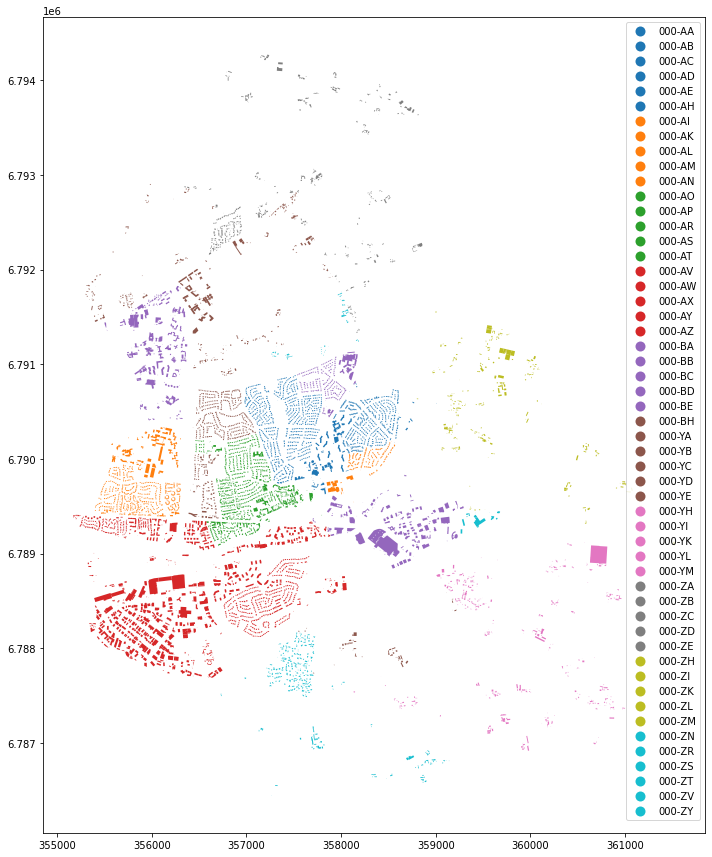

In [ ]:
# Faire une carte des batiments catégorisée par code de section

map2 = BatiOK.plot(figsize=(15,15), column='ID_Section', legend=True).get_figure()

In [ ]:
# Calculer le  nombre de batiments par sections cadastrale

NbBatiSection = BatiOK[["ID_Section", "ID_Bati"]].groupby("ID_Section").size()
NbBatiSection = pd.DataFrame(NbBatiSection)
NbBatiSection = NbBatiSection.rename(columns={0: 'NbBatis'})
NbBatiSection.head(3)

,NbBatis
ID_Section,
000-AA,475
000-AB,263
000-AC,112


In [ ]:
# Compter le nombre de batiment (vérification)

total1 = Batiments['geometry'].count()
total2 = NbBatiSection['NbBatis'].sum()
print(total1)
print(total1)

9047
9047


In [ ]:
# Jointure attributaire pour repasser sur la couche des sections cadastrales

Sections = Sections.merge(NbBatiSection, on='ID_Section')
Sections.head(3)

,id,commune,prefixe,code,created,updated,geometry,ID_Section,Surface_Section,NbBatis
0,35051000AA,35051,000,AA,2020-06-16,2020-06-22,"POLYGON ((357095.719 6790338.898, 357089.990 6...",000-AA,369064.681658,475
1,35051000AB,35051,000,AB,2020-06-16,2020-06-22,"POLYGON ((357603.646 6790021.629, 357544.963 6...",000-AB,214286.256561,263
2,35051000AC,35051,000,AC,2020-06-16,2020-06-22,"POLYGON ((357841.087 6789716.194, 357850.289 6...",000-AC,142503.178738,112


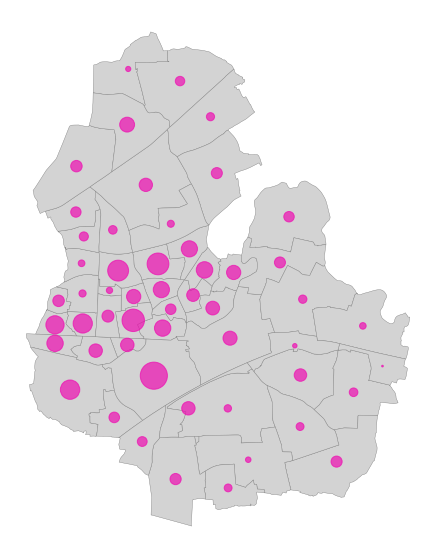

In [ ]:
# Faire une carte pour représenter le nombre de batiments pas section cadastrale

SectionsCentro = Sections.copy()
SectionsCentro.geometry = SectionsCentro['geometry'].centroid

map3, ax = plt.pyplot.subplots(figsize=(10,10))
Sections.plot(ax=ax, color="lightgray", edgecolor="grey", linewidth=0.4)
SectionsCentro.plot(ax=ax,color="#ee0db1", markersize="NbBatis",alpha=0.7, categorical=False, legend=True)
ax.axis("off")
plt.pyplot.show()

## Compter le nombre de bâtiments par parcelle cadastrale

In [ ]:
# Calculer le Nombre de batiments par parcelle cadastrale

NbBatiParcelle  = BatiOK[["ID_Parcelle", "ID_Bati"]].groupby("ID_Parcelle").size()
NbBatiParcelle =pd.DataFrame(NbBatiParcelle)
NbBatiParcelle = NbBatiParcelle.rename(columns={0: 'NbBatis'})
NbBatiParcelle.head(5)

,NbBatis
ID_Parcelle,
000-AA-10,2
000-AA-100,1
000-AA-101,1
000-AA-102,1
000-AA-103,1


In [ ]:
# Compter le nombre de batiment

total1 = Batiments['geometry'].count()
total2 = NbBatiParcelle['NbBatis'].sum()
print(total1)
print(total1)

9047
9047


In [ ]:
# Jointure attributaire pour repasser sur la couche des parcelles  cadastrales

Parcellesbis = Parcelles.merge(NbBatiParcelle, on='ID_Parcelle')
Parcellesbis.head(3)

,id,commune,prefixe,section,numero,contenance,created,updated,geometry,ID_Parcelle,Surface_Parcelle,NbBatis
0,35051000AA0562,35051,000,AA,562,42655.0,2020-06-16,2021-01-29,"POLYGON ((357147.131 6790343.595, 357174.713 6...",000-AA-562,42589.708869,1
1,35051000AA0192,35051,000,AA,192,6752.0,2020-06-16,2021-01-29,"POLYGON ((357526.866 6790865.979, 357527.840 6...",000-AA-192,6609.165909,1
2,35051000AA0059,35051,000,AA,59,619.0,2020-06-16,2021-01-29,"POLYGON ((357024.044 6790482.974, 357016.068 6...",000-AA-59,621.336887,1


/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


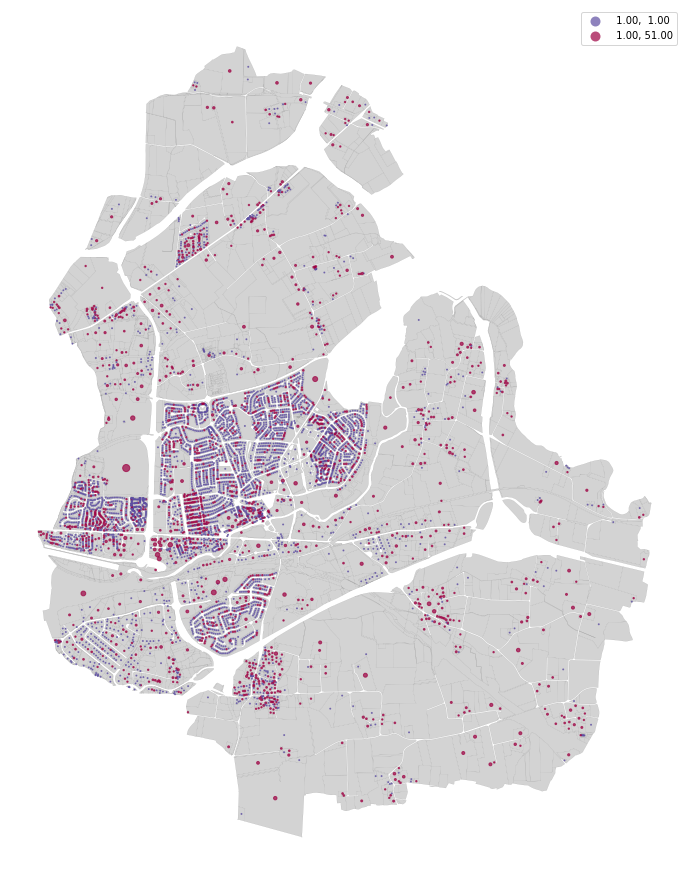

In [ ]:
# Faire une carte pour représenter le nombre de batiments par parcelle cadastrale

Parcellescentro = Parcellesbis.copy()
Parcellescentro.geometry = Parcellescentro['geometry'].centroid

map4, ax = plt.pyplot.subplots(figsize=(16,16))
Parcelles.plot(ax=ax, color="lightgray", edgecolor="grey", linewidth=0.1)
Parcellescentro.plot(ax=ax, markersize="NbBatis", column='NbBatis', cmap='Spectral_r',k=3, scheme='quantiles', alpha=0.7, legend=True)
ax.axis("off")
plt.pyplot.show()

## Calculer la proportion de surface des bâtiments par parcelle cadastrale (tx de recouvrement)

In [ ]:
BatiOK.head(3)

,ID_Bati,type,Surface_Batiment,ID_Section,Surface_Section,ID_Parcelle,Surface_Parcelle,Geometry
0,0,01,100.642954,000-AA,369064.681658,000-AA-126,584.534522,"POLYGON ((357222.008 6790493.977, 357213.758 6..."
1,1,01,92.067686,000-AA,369064.681658,000-AA-124,470.937329,"POLYGON ((357187.130 6790473.351, 357193.638 6..."
2,2,01,114.465134,000-AA,369064.681658,000-AA-119,511.476178,"POLYGON ((357208.471 6790399.177, 357213.178 6..."


In [ ]:
# Calculer la proportion des surfaces baties par parcelle cadastrale

recap = BatiOK.groupby('ID_Parcelle').agg({'Surface_Batiment':'sum','Surface_Parcelle':'max'})
recap["propbatiparcelle"] = recap["Surface_Batiment"] / recap["Surface_Parcelle"] *100
recap.head()

,Surface_Batiment,Surface_Parcelle,propbatiparcelle
ID_Parcelle,,,
000-AA-10,99.817772,796.936781,12.525181
000-AA-100,84.995102,421.926421,20.144532
000-AA-101,139.104492,644.720353,21.575942
000-AA-102,111.440761,528.437946,21.088713
000-AA-103,91.291023,606.391468,15.054800


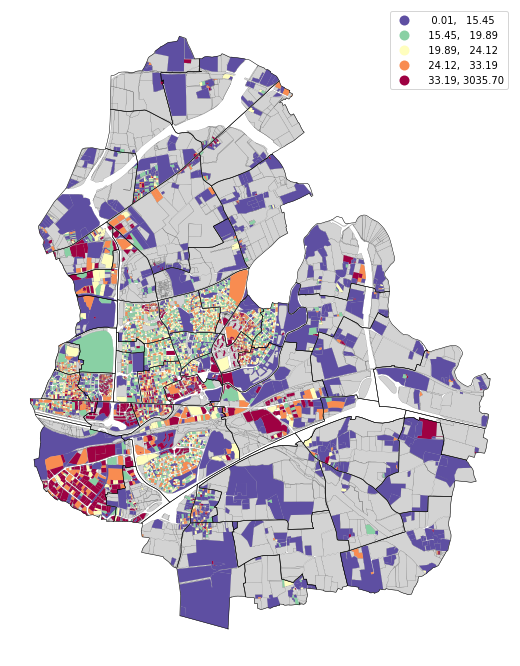

In [ ]:
# Faire la jointure attributaire avec la couche des parcelles cadastrales et la carte

Parcellesok = Parcellesbis.merge(recap, on='ID_Parcelle')
Parcellesok.head()

map5, ax = plt.pyplot.subplots(figsize=(12,12))
Sections.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)
Parcelles.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.1)
Parcellesok.plot(ax=ax, column='propbatiparcelle', cmap='Spectral_r',scheme='quantiles', legend=True)
ax.axis("off")
plt.pyplot.show()

In [ ]:
#Téléchargement des datas depuis le portail opendata de Rennes
!wget https://data.rennesmetropole.fr/explore/dataset/reseau_hydrographique/download/?format=geojson&timezone=Europe/Berlin&lang=fr -O hydrographie.geojson
!wget -O PLU.geojson https://data.rennesmetropole.fr/explore/dataset/synthese_plui_2021/download/?format=geojson&timezone=Europe/Berlin&lang=fr

--2022-03-11 17:14:35--  https://data.rennesmetropole.fr/explore/dataset/reseau_hydrographique/download/?format=geojson
/bin/bash: -O: command not found
Resolving data.rennesmetropole.fr (data.rennesmetropole.fr)... 34.248.20.69, 34.249.199.226
Connecting to data.rennesmetropole.fr (data.rennesmetropole.fr)|34.248.20.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘index.html?format=geojson.17’

index.html?format=g     [           <=>      ]  16.48M  4.37MB/s    in 3.8s    

2022-03-11 17:14:40 (4.37 MB/s) - ‘index.html?format=geojson.17’ saved [17284840]

--2022-03-11 17:14:41--  https://data.rennesmetropole.fr/explore/dataset/synthese_plui_2021/download/?format=geojson
Resolving data.rennesmetropole.fr (data.rennesmetropole.fr)... 34.248.20.69, 34.249.199.226
Connecting to data.rennesmetropole.fr (data.rennesmetropole.fr)|34.248.20.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspec

# Etude sur Cesson

## Zonage et PLU 

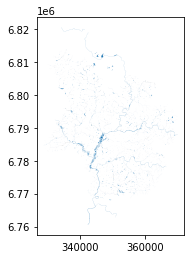

In [ ]:
#Chargement couche hydrographie
Hydrographie= gpd.read_file("hydrographie.geojson", encoding='utf-8')
Hydrographie = Hydrographie.to_crs("EPSG:2154")
Hydrographie.head()
Hydrographie.plot()

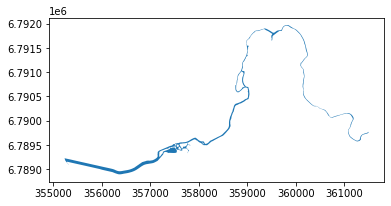

In [ ]:
# Ne garder que les troncons de tyoe "fleuve" dans la commune de Cesson
Fleuve = Hydrographie[(Hydrographie["type_hydro_nom"] == 'fleuve')]
HydroCesson = gpd.overlay(Fleuve, Cesson, how='intersection')
HydroCesson.plot()

,geometry,hydro_date_maj,objectid,deno_hydro_id,gml_id,hydro_code_insee,ope_id,type_hydro_id,type_hydro_nom,hydro_visible,id,prefixe,code,created,updated,ID_Section,Surface_Section
deno_hydr_nom,,,,,,,,,,,,,,,,,
la Vilaine,"POLYGON ((355425.186 6788811.131, 355423.363 6...",2020-07-23,3747,2.0,v_hydro.3747,35051.0,1.0,3,fleuve,1,35051000AA,000,AA,2020-06-16,2020-06-22,000-AA,369064.681658


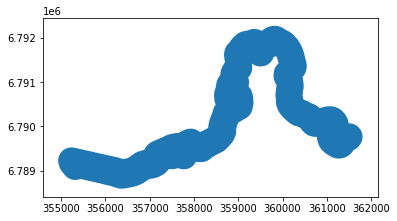

In [ ]:
#Faire un buffer de 300m autour de la couche hydro

HydroCesson['geometry'] = HydroCesson['geometry'].buffer(300)
HydroCesson = HydroCesson.dissolve(by ='deno_hydr_nom')
HydroCesson.plot()
HydroCesson.head()


,objectid,semio,typezone,datevalid,gml_id,libelle,perimetre_geo,id_rm,aire_geo,geometry
0,3581,None,A,20200910,plui_synthese_2021.3581,A,27649.22,3588,7314465.64,"MULTIPOLYGON (((344457.097 6802558.021, 344411..."
1,3773,None,A,20200910,plui_synthese_2021.3773,A,13647.51,3782,2767384.21,"MULTIPOLYGON (((363746.240 6779990.971, 363759..."
2,3621,None,Ah,20200910,plui_synthese_2021.3621,Ai,246.09,3628,3262.88,"MULTIPOLYGON (((350607.515 6793646.454, 350600..."


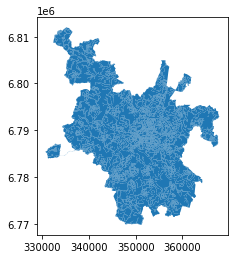

In [ ]:
#Chargement couche du PLU
PLU= gpd.read_file("PLU.geojson", encoding='utf-8')
PLU = PLU.to_crs("EPSG:2154")
PLU.plot()
PLU.head(3)

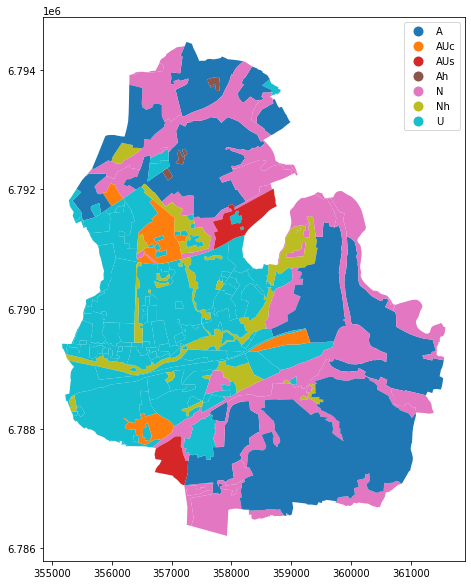

In [ ]:
#Ne garder sur le PLU de Cesson
PLUCesson = gpd.overlay(PLU, Cesson, how='intersection')
PLUCesson.plot(figsize=(10,10),column='typezone', legend=True)

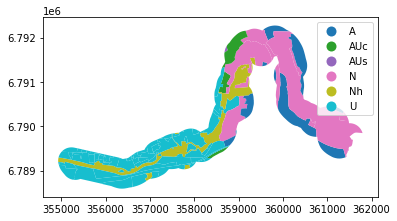

In [ ]:
# Garder le zonage situés à moins de 300m de la Vilaine
Zonagerisque = gpd.overlay(PLU, HydroCesson, how='intersection')
Zonagerisque.plot(column = 'typezone', legend = True)

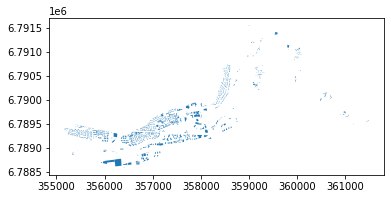

In [ ]:
# Garder les bâtiments situés à moins de 300m de la Vilaine
Batirisque = gpd.overlay(Batiments, HydroCesson, how='intersection')
Batirisque.plot()

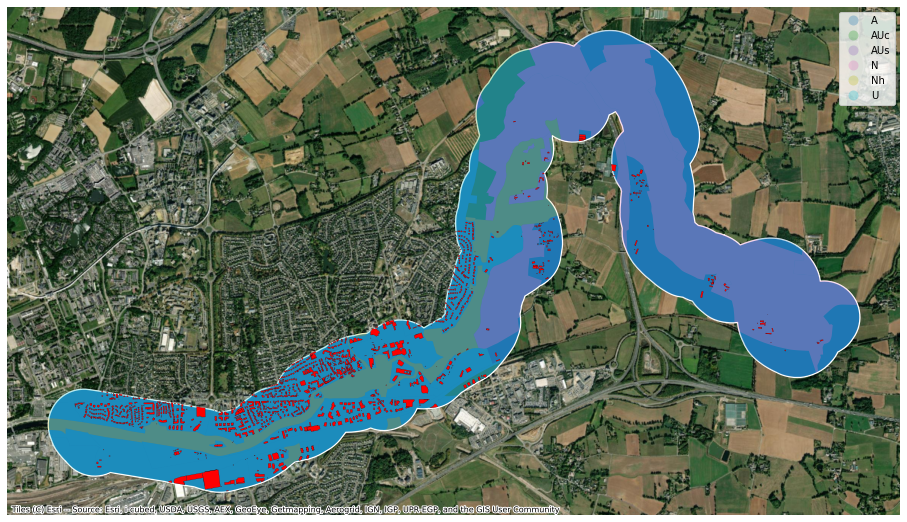

In [ ]:
#Carte récapitulative

map5, ax = plt.pyplot.subplots(figsize=(16,16))
HydroCesson.to_crs('EPSG:3857').plot(ax=ax, edgecolor="white", linewidth=1.3 )
Zonagerisque.to_crs('EPSG:3857').plot(ax = ax, column = 'typezone', legend = True, alpha=0.3)
Batirisque.to_crs('EPSG:3857').plot(ax=ax, color="red",edgecolor="black", linewidth=0.15)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
ax.axis("off")
plt.pyplot.show()

,commune,nom,type,created_left,updated_left,geometry,ID_Bati,Surface_Batiment,index_right,objectid,...,perimetre_geo,id_rm,aire_geo,id,prefixe,code,created_right,updated_right,ID_Section,Surface_Section
0,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357222.008 6790493.977, 357213.758 6...",0,100.642954,110,3783,...,9284.87,3792,801679.82,35051000AA,000,AA,2020-06-16,2020-06-22,000-AA,369064.681658
1,35051,None,01,2020-06-16,2020-06-22,"POLYGON ((357187.130 6790473.351, 357193.638 6...",1,92.067686,110,3783,...,9284.87,3792,801679.82,35051000AA,000,AA,2020-06-16,2020-06-22,000-AA,369064.681658


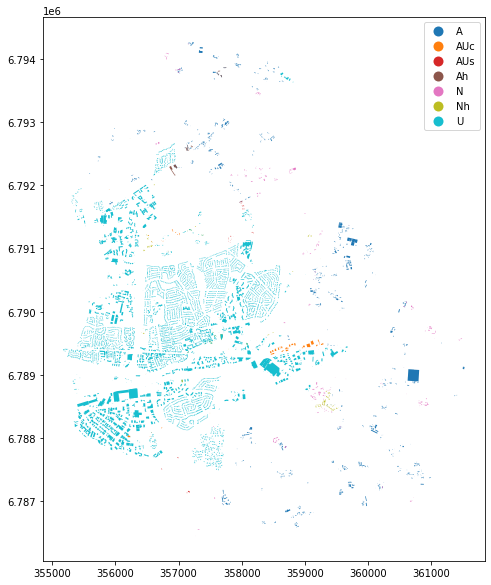

In [ ]:
# Encrichir les batiments des informations de la couche PLU (jointure spatiale)

BatimentsPLU = gpd.sjoin(Batiments, PLUCesson)
BatimentsPLU.plot(figsize=(10,10),column='typezone', legend=True)
BatimentsPLU.head(2)

,ID_Bati
typezone,
A,1072
AUc,71
AUs,30
Ah,31
N,293


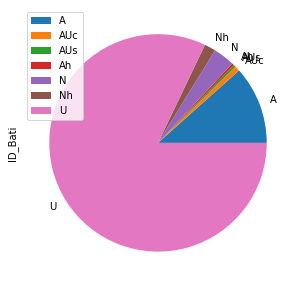

In [ ]:
# Graphie du nombre de bâtiments par zonage

Categorie = BatimentsPLU[["typezone", "ID_Bati"]].groupby("typezone").count()
Categorie.plot.pie(figsize =(14,5), y="ID_Bati" )
Categorie.head()
